In [26]:
# !pip install yfinance
# !pip install bs4
# !pip install nbformat
# !pip install matplotlib
# !pip install html5lib


import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options

warnings.filterwarnings("ignore", category=FutureWarning)

## Define a Function 

First I define a Graphing Function for stock prices and revenue. It takes a dataframe with stock data (dataframe must contain Date and Close columns), a dataframe with revenue data (dataframe must contain Date and Revenue columns), and the name of the stock.

In [27]:
def make_graph(stock_data, revenue_data, stock):
    
    stock_data["Date"] = pd.to_datetime(stock_data["Date"], errors="coerce")
    revenue_data["Date"] = pd.to_datetime(revenue_data["Date"], errors="coerce")

    stock_data = stock_data.dropna(subset=["Date"])
    revenue_data = revenue_data.dropna(subset=["Date"])

    # Filter dates for assignment requirement
    stock_data_specific = stock_data[stock_data["Date"] <= "2025-09-30"]
    revenue_data_specific = revenue_data[revenue_data["Date"] <= "22025-09-30"]


    if stock_data_specific.empty or revenue_data_specific.empty:
        print("Warning: One of the datasets is empty after filtering.")
        return


    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Stock price
    axes[0].plot(pd.to_datetime(stock_data_specific.Date), stock_data_specific.Close.astype("float"), label="Share Price", color="blue")
    axes[0].set_ylabel("Price ($US)")
    axes[0].set_title(f"{stock} - Historical Share Price")

    # Revenue
    axes[1].plot(pd.to_datetime(revenue_data_specific.Date), revenue_data_specific.Revenue.astype("float"), label="Revenue", color="green")
    axes[1].set_ylabel("Revenue ($US Millions)")
    axes[1].set_xlabel("Date")
    axes[1].set_title(f"{stock} - Historical Revenue")

    plt.tight_layout()
    plt.show()

## Webscraping for Revenue Data

Here I will use the library **selenium** to download webpages of [Nvidia](https://www.macrotrends.net/stocks/charts/NVDA/nvidia/revenue), [SAP](https://www.macrotrends.net/stocks/charts/SAP/sap-se/revenue), [Apple](https://www.macrotrends.net/stocks/charts/AAPL/apple/revenue) and [Microsoft](https://www.macrotrends.net/stocks/charts/MSFT/microsoft/revenue). I will save the data in a html file. Furthone parse the information and store the information in a dataframe with the help of the library **BeautifullSoup**. I will then display the information with **matplotlib**.

Data shape: (60, 2)

First 10 rows:
         Date  Revenue
0  2025-10-31    57006
1  2025-07-31    46743
2  2025-04-30    44062
3  2025-01-31    39331
4  2024-10-31    35082
5  2024-07-31    30040
6  2024-04-30    26044
7  2024-01-31    22103
8  2023-10-31    18120
9  2023-07-31    13507

Last 10 rows:
          Date  Revenue
50  2013-04-30      955
51  2013-01-31     1107
52  2012-10-31     1204
53  2012-07-31     1044
54  2012-04-30      925
55  2012-01-31      953
56  2011-10-31     1066
57  2011-07-31     1017
58  2011-04-30      962
59  2011-01-31      886


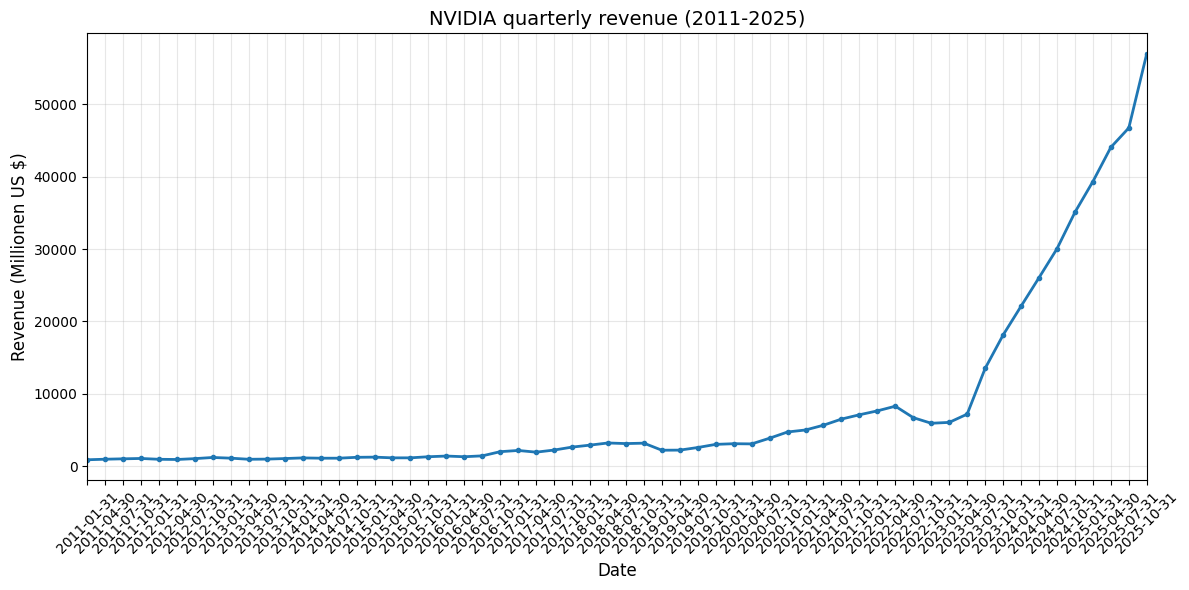

In [29]:

# Setup Chrome options
chrome_options = Options()
chrome_options.add_argument("--headless")  # Run in background
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Initialize driver
driver = webdriver.Chrome(options=chrome_options)

try:
    url_nvda = "https://www.macrotrends.net/stocks/charts/NVDA/nvidia/revenue"
    driver.get(url_nvda)
    
    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.TAG_NAME, "table"))
    )
    
    # Get page source after JS execution
    html_data_nvda = driver.page_source
    
    # Find all tables
    tables = pd.read_html(html_data_nvda)
    
    # Get the quarterly revenue table (table 1)
    nvidia_revenue = tables[1].copy()
    
    # Rename columns for easier access
    nvidia_revenue.columns = ['Date', 'Revenue']
    
    # Clean data - remove $, commas, empty strings and nulls
    nvidia_revenue["Revenue"] = nvidia_revenue["Revenue"].str.replace(r',|\$',"",regex=True)
    nvidia_revenue.dropna(inplace=True)
    nvidia_revenue = nvidia_revenue[nvidia_revenue['Revenue'] != ""]
    
    # Convert revenue to numeric
    nvidia_revenue['Revenue'] = pd.to_numeric(nvidia_revenue['Revenue'], errors='coerce')
    
    # Remove any NaN values after conversion
    nvidia_revenue.dropna(inplace=True)
    
    print(f"Data shape: {nvidia_revenue.shape}")
    print(f"\nFirst 10 rows:\n{nvidia_revenue.head(10)}")
    print(f"\nLast 10 rows:\n{nvidia_revenue.tail(10)}")
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(nvidia_revenue["Date"], nvidia_revenue["Revenue"], marker='o', markersize=3, linewidth=2)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Revenue (Millionen US $)", fontsize=12)
    plt.title("NVIDIA quarterly revenue (2011-2025)", fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.xlim(nvidia_revenue['Date'].min(), nvidia_revenue['Date'].max())  # Set x-axis limits
    plt.tight_layout()
    plt.show()

finally:
    driver.quit()